<a href="https://colab.research.google.com/github/swarnava-96/Financial-Analytics-with-Python/blob/main/AAPL_Stock_Price_Prediction_And_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AAPL Stock Price Prediction And Forecasting Using Stacked LSTM**
Data source: Tingo and Pandas Data Reader

In [1]:
cd "/content/drive/MyDrive/Datasets"

/content/drive/MyDrive/Datasets


### Importing the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Data Collection

In [3]:
# Lets import pandas datareader and lets use Tingo API key for getting the AAPL stock price data

import pandas_datareader as pdr
key = "2829ba880e3e141847f068068cd757a771d9a0ef"

In [4]:
# Lets extract the AAPL stock data

df = pdr.get_data_tiingo("AAPL", api_key = key)

In [5]:
# Lets convert the data extracted into csv

df.to_csv("AAPL.csv")

### Loading the Data

In [6]:
df = pd.read_csv("AAPL.csv")
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-09-12 00:00:00+00:00,105.44,105.72,102.53,102.65,45292770,24.717011,24.782648,24.034855,24.062985,181171080,0.0,1.0
1,AAPL,2016-09-13 00:00:00+00:00,107.95,108.79,107.24,107.51,62176190,25.305400,25.502310,25.138963,25.202256,248704760,0.0,1.0
2,AAPL,2016-09-14 00:00:00+00:00,111.77,113.03,108.60,108.73,112340318,26.200875,26.496242,25.457771,25.488245,449361272,0.0,1.0
3,AAPL,2016-09-15 00:00:00+00:00,115.57,115.73,113.49,113.86,90613177,27.091663,27.129170,26.604074,26.690809,362452708,0.0,1.0
4,AAPL,2016-09-16 00:00:00+00:00,114.92,116.13,114.04,115.12,79886911,26.939291,27.222937,26.733004,26.986175,319547644,0.0,1.0


In [7]:
# Lets chech the last five rows

df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,AAPL,2021-09-01 00:00:00+00:00,152.51,154.98,152.340,152.83,80313711,152.51,154.98,152.340,152.83,80313711,0.0,1.0
1253,AAPL,2021-09-02 00:00:00+00:00,153.65,154.72,152.400,153.87,71171317,153.65,154.72,152.400,153.87,71171317,0.0,1.0
1254,AAPL,2021-09-03 00:00:00+00:00,154.30,154.63,153.090,153.76,57866066,154.30,154.63,153.090,153.76,57866066,0.0,1.0
1255,AAPL,2021-09-07 00:00:00+00:00,156.69,157.26,154.390,154.97,82278261,156.69,157.26,154.390,154.97,82278261,0.0,1.0
1256,AAPL,2021-09-08 00:00:00+00:00,155.11,157.04,153.975,156.98,74420207,155.11,157.04,153.975,156.98,74420207,0.0,1.0


We can see that we have last five years Apple Stock price data. Several features are there but I will consider only one feature i.e. "close". And based on that we will forecast the stock price of next 30 days.

In [8]:
df1 = df.reset_index()["close"]
df1

0       105.44
1       107.95
2       111.77
3       115.57
4       114.92
         ...  
1252    152.51
1253    153.65
1254    154.30
1255    156.69
1256    155.11
Name: close, Length: 1257, dtype: float64

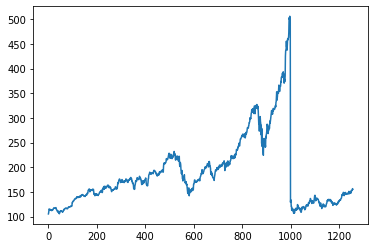

In [9]:
# Lets plot the dataset
plt.plot(df1);

### Data Pre-processing
LSTM are sensitive to the scale of the data. so we apply MinMax scaler.

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)

[[0.        ]
 [0.00626482]
 [0.01579933]
 ...
 [0.12195183]
 [0.12791713]
 [0.12397354]]


Now, we will split the array into train and test. Since it is a time series data, so we will take the 65% of the data as train and the remaining 35% as test. 

In [11]:
training_size = int(len(df) * 0.65)
test_size = len(df) - training_size
train_data, test_data = df1[0 : training_size, :], df1[training_size : len(df1), : 1]

In [12]:
# Lets check the trainin size
training_size

817

In [13]:
# Lets check the test size
test_size

440

In [14]:
# Lets check the train data

train_data

array([[0.        ],
       [0.00626482],
       [0.01579933],
       [0.02528391],
       [0.02366155],
       [0.02031698],
       [0.02029203],
       [0.02024211],
       [0.02291277],
       [0.01814551],
       [0.01856982],
       [0.01909397],
       [0.02124048],
       [0.01682266],
       [0.01899413],
       [0.01767128],
       [0.01886934],
       [0.01899413],
       [0.02109073],
       [0.02151504],
       [0.02648197],
       [0.02710595],
       [0.02970173],
       [0.02880319],
       [0.03042556],
       [0.03022588],
       [0.03002621],
       [0.02915263],
       [0.02900287],
       [0.02785474],
       [0.03047548],
       [0.03197304],
       [0.02533383],
       [0.02256333],
       [0.02066642],
       [0.02021715],
       [0.01510046],
       [0.01535006],
       [0.01095719],
       [0.00848621],
       [0.01240484],
       [0.01402721],
       [0.01357794],
       [0.00586547],
       [0.00746287],
       [0.0006739 ],
       [0.00416823],
       [0.011

In [15]:
# Lets convert this array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [16]:
# Reshape into X=t,t+1,t+2,t+3 and Y=t+4

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [17]:
# Lets check the shape of X_train and y_train
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [18]:
print(X_test.shape), print(y_test.shape)

(339, 100)
(339,)


(None, None)

In [19]:
# Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [23]:
X_train.shape

(716, 100, 1)

### Model Building

In [20]:
!pip install tensorflow==2.5

In [21]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [22]:
# Lets import the model and layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [24]:
# Lets create the stacked LSTM

model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [25]:
# Lets check our model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Model Fitting

model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
12/12 [==============================] - 9s 344ms/step - loss: 0.0105 - val_loss: 0.0367
Epoch 2/100
12/12 [==============================] - 3s 219ms/step - loss: 0.0029 - val_loss: 0.0263
Epoch 3/100
12/12 [==============================] - 3s 218ms/step - loss: 0.0015 - val_loss: 0.0241
Epoch 4/100
12/12 [==============================] - 3s 215ms/step - loss: 8.8186e-04 - val_loss: 0.0218
Epoch 5/100
12/12 [==============================] - 3s 218ms/step - loss: 6.1733e-04 - val_loss: 0.0232
Epoch 6/100
12/12 [==============================] - 3s 216ms/step - loss: 5.3717e-04 - val_loss: 0.0234
Epoch 7/100
12/12 [==============================] - 3s 212ms/step - loss: 5.1577e-04 - val_loss: 0.0225
Epoch 8/100
12/12 [==============================] - 3s 214ms/step - loss: 4.9076e-04 - val_loss: 0.0224
Epoch 9/100
12/12 [==============================] - 3s 213ms/step - loss: 4.9108e-04 - val_loss: 0.0232
Epoch 10/100
12/12 [==============================] - 3s 213ms/step

### Model Evaluation

In [27]:
# Lets do the prediction and check the performance metrics

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [28]:
# Transforming back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [29]:
# Lets calculate the RMSE 
import math
from sklearn.metrics import mean_squared_error

# lets calculate the RMSE for the train data
print("RMSE for train data is ",math.sqrt(mean_squared_error(y_train, train_predict)))

# Lets calculate the RMSE for the test data
print("RMSE for test data is ",math.sqrt(mean_squared_error(y_test, test_predict)))

RMSE for train data is  182.93591874730055
RMSE for test data is  208.38340885596705


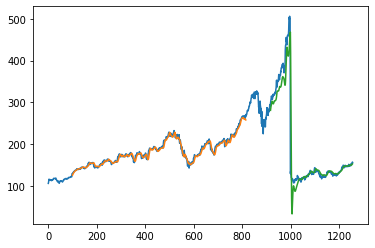

In [31]:
#lets visualize

# Shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict) + look_back, :] = train_predict

# Shift test predict for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back*2) + 1: len(df) - 1, :] = test_predict

# Plotting the baseline and prediction
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show();

### Future Prediction

In [33]:
# Lets see the length of our test data

len(test_data)

440

In [34]:
# We will take the previous 100 days data for predicting the next day

x_input = test_data[340 :].reshape(1, -1)
x_input.shape

(1, 100)

In [36]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input

[0.0733807562710595,
 0.06906277299388497,
 0.07003619118931736,
 0.06614251840758767,
 0.07208286534381625,
 0.07308124298015722,
 0.07225758143017591,
 0.07023586671658555,
 0.06998627230750026,
 0.06494446524397857,
 0.06764008486209905,
 0.055934107076001494,
 0.05655809309871457,
 0.0606514414077125,
 0.06182453513041308,
 0.053438162985149085,
 0.05109197553974787,
 0.04325471109447143,
 0.048745788094346654,
 0.05493572943966052,
 0.05199051541245475,
 0.04844627480344438,
 0.04804692374890801,
 0.0545862972669412,
 0.049893922376138766,
 0.054062149007862215,
 0.053562960189691755,
 0.053438162985149085,
 0.04951953076251092,
 0.047847248221639826,
 0.04702358667165857,
 0.048970423062523416,
 0.04517658804442781,
 0.05104205665793082,
 0.0510670160988394,
 0.05316360913515533,
 0.054137027330587784,
 0.051591164357918384,
 0.05468613503057529,
 0.0624984400349432,
 0.06040184699862716,
 0.061674778484961945,
 0.06576812679395977,
 0.06244852115312616,
 0.06704105828029455,
 0.

In [49]:
# Demonstrate prediction for next 10 days

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.04897042 0.04517659 0.05104206 0.05106702 0.05316361 0.05413703
 0.05159116 0.05468614 0.06249844 0.06040185 0.06167478 0.06576813
 0.06244852 0.06704106 0.07123424 0.07053538 0.06981156 0.06906277
 0.073231   0.07709971 0.07867216 0.0794459  0.08615999 0.09130163
 0.09766629 0.09434669 0.0990141  0.09749158 0.10033695 0.10909772
 0.10742543 0.10220891 0.09237489 0.10160988 0.09973793 0.10323225
 0.10762511 0.10869837 0.10315737 0.09868963 0.10033695 0.10088606
 0.10003744 0.10462998 0.10360664 0.10388119 0.10158492 0.10146013
 0.10023711 0.10088606 0.10844877 0.10897292 0.11401473 0.1116935
 0.10213403 0.10298265 0.10670161 0.11049544 0.11027081 0.10712592
 0.10507925 0.10772495 0.11900661 0.11578685 0.11748409 0.12032946
 0.12195183 0.12791713 0.12397354 0.12086674 0.12254965 0.12360206
 0.12415245 0.12437342 0.12441441 0.12438034 0.12433378 0.12430634
 0.12431017 0.12434731 0.1244154  0.12451044 0.12462833 0.1247651
 0.12491703 0.12508065 0.12525256 0.12542966 0.12560

In [50]:
# Predicting for the next 30 days

day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [51]:
# Lets check the length of our dataset
len(df1)

1257

In [52]:
# As we will take previous 100 days
1257-100

1157

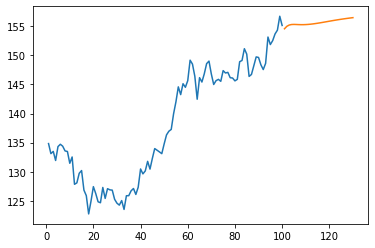

In [54]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(list_output))

Here, the orange line show our prediction.